In [162]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Ruta al archivo .mseed
data_directory = '../../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed'
mseed_file = f'{data_directory}'

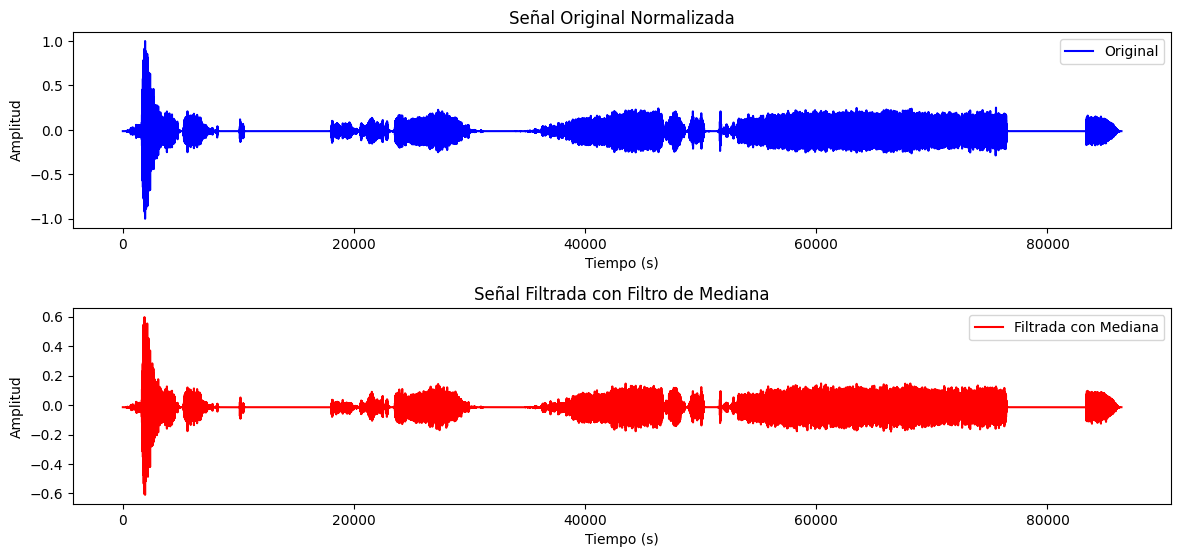

In [163]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Leer el archivo mseed
st = read(mseed_file)
tr = st[0].copy()  # Obtener la primera traza

# Aplicar el filtro de banda
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtener datos de la traza filtrada
tr_times = tr.times()
tr_data = tr.data

# Normalización Min-Max
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Aplicar un Filtro de Mediana
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualizar las señales
plt.figure(figsize=(12, 8))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(tr_times, tr_data_minmax, 'b-', label='Original')
plt.title('Señal Original Normalizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Señal Filtrada con Mediana
plt.subplot(3, 1, 2)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

In [164]:
import noisereduce as nr
sample_rate = 1 / (tr_times[1] - tr_times[0])  # Calcular tasa de muestreo
signal_cleaned = nr.reduce_noise(y=tr_data_median_filtered, sr=sample_rate, time_mask_smooth_ms=40000)

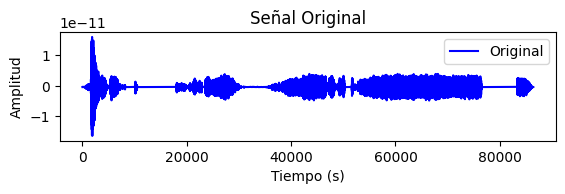

In [165]:
plt.subplot(3, 1, 1)
plt.plot(tr_times, signal_cleaned , 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

Text(0, 0.5, 'Characteristic function')

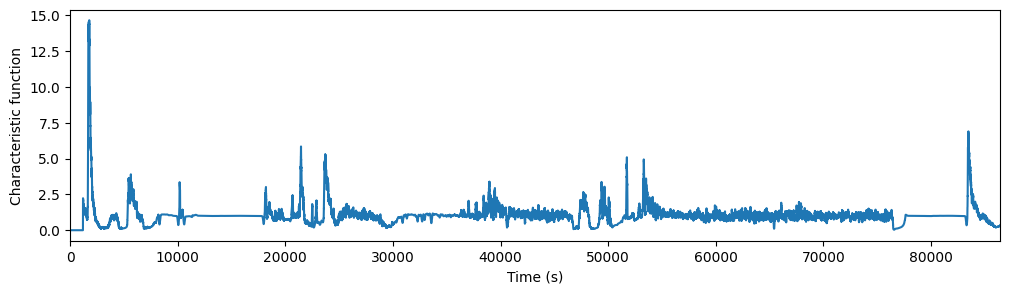

In [167]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 60
lta_len = 1200

# Run Obspy's STA/LTA to obtain a characteristic function
cft = classic_sta_lta(signal_cleaned, int(sta_len * df), int(lta_len * df))

# Definir el tiempo mínimo de duración de los eventos (en segundos)
min_duration = 420 # Puedes ajustarlo según tus necesidades

# Convertir el tiempo mínimo de duración a muestras
min_duration_samples = int(min_duration * df)
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

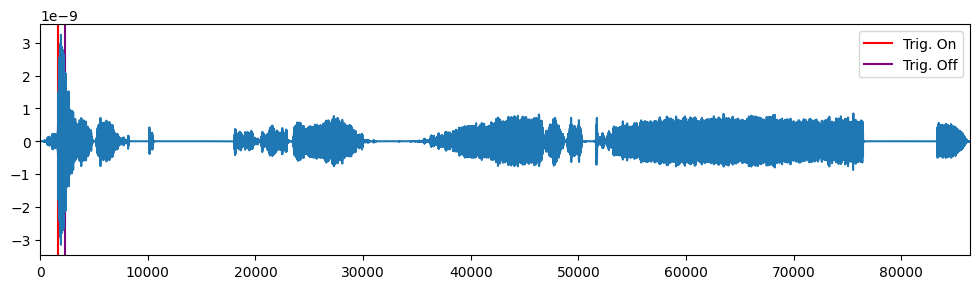

In [169]:
# Definir los umbrales para la activación y desactivación
thr_on = 7
thr_off = 1
on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Filtrar los eventos que duran menos que el tiempo mínimo
filtered_on_off = []
for triggers in on_off:
    # Verificar si la duración del evento es mayor que el mínimo
    if (triggers[1] - triggers[0]) >= min_duration_samples:
        filtered_on_off.append(triggers)

# Convertir la lista filtrada de nuevo a un array de NumPy
filtered_on_off = np.array(filtered_on_off)

# Plot on and off triggers (solo los filtrados)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
for i in np.arange(0, len(filtered_on_off)):
    triggers = filtered_on_off[i]
    ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times, tr_data)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.legend()
plt.show()